# UNSEEN trends in the MPI-ESM1-2-HR hindcast

Australian temperature extremes (TXx; annual maximum).

## Analysis

- Generate a list of model data paths.
- Import and subset datasets using unseen
- Calculate tx1day at point
- Validate model using AGCD
  - Correct any biases
- Calculate NS-GEV parameters
- Check independence and stability
  - check dependence on lead time by plotting ensemble member correlation as a function of lead time
  - Drop lead times with high R_p
- Plot time series, histogram and return value.


plotting maps issues:
- increase dataset name
- add tasmax ticks (i.e., 20-65)
- pass plot axis for subplots

In [1]:
%load_ext autoreload
%autoreload 2

import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
from datetime import datetime
import geopandas as gp
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import AutoLocator, AutoMinorLocator, MaxNLocator, FixedLocator
import numpy as np
from pathlib import Path
from scipy.stats import genextreme, mode
import sys
import xarray as xr
import xesmf as xe

# from unseen.fileio import open_dataset, open_mfforecast
from unseen.spatial_selection import select_shapefile_regions
from unseen import independence, stability, eva, general_utils

sys.path.append("/g/data/xv83/as3189/plotting_maps/")
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict

In [6]:
home = Path("/g/data/xv83/unseen-projects/outputs/hazards")
model = "MPI-ESM1-2-HR"
dataset_name = ["AGCD", model]
var = "tasmax"
index = "TXx"
timescale = "annual-jul-to-jun"
units = "Temperature [°C]"
# Land-sea mask
gdf = gp.read_file(home / "shapefiles/australia.shp")
plot_kwargs = dict(
    name="aus_states_territories",
    regions=regions_dict["aus_states_territories"],
    mask_not_australia=True,
    figsize=(8 / 4, 6 / 4),
    area_linewidth=0.1,
    xlim=(110, 170),
    ylim=(-45, -5),
    label_states=False,
    contourf=False,
    contour=False,
    select_area=None,
    land_shadow=True,
    # watermark=None,
)

In [4]:
def regrid_like(ds, ds_like, method="conservative"):
    """Regrid `ds` to the grid of `ds_like` using xESMF"""
    assert ds.dims[-2:] == ("lat", "lon"), "Last two dimensions must be lat and lon"
    grid_in = xr.Dataset(
        {
            "lat": (["lat"], ds.lat.values, {"units": "degrees_north"}),
            "lon": (["lon"], ds.lon.values, {"units": "degrees_east"}),
        }
    )
    grid_out = xr.Dataset(
        {
            "lat": (["lat"], ds_like.lat.values, {"units": "degrees_north"}),
            "lon": (["lon"], ds_like.lon.values, {"units": "degrees_east"}),
        }
    )
    regridder = xe.Regridder(grid_in, grid_out, method)
    return regridder(ds)

### Observational Data (AGCD)


In [5]:
# Observational data
file_obs = home / f"data/{index.lower()}_AGCD-CSIRO_r05_1910-2023_{timescale}_aus.nc"
ds_obs = xr.open_dataset(str(file_obs), use_cftime=True, chunks="auto")
# Apply land-sea mask
ds_obs = select_shapefile_regions(ds_obs, gdf, overlap_fraction=0.95)
# Format event time as datetime
ds_obs["event_time"] = ds_obs.event_time.astype(dtype="datetime64[ns]")
# Drop years before model data is available
ds_obs = ds_obs.sel(time=slice("1960", None))
ds_obs

<xarray.Dataset> Size: 4MB
Dimensions:     (time: 64, lat: 59, lon: 79)
Coordinates:
  * lat         (lat) float64 472B -43.0 -42.5 -42.0 -41.5 ... -12.5 -12.0 -11.5
  * lon         (lon) float64 632B 114.0 114.5 115.0 115.5 ... 152.0 152.5 153.0
  * time        (time) object 512B 1960-06-30 00:00:00 ... 2023-06-30 00:00:00
    event_time  (time, lat, lon) datetime64[ns] 2MB dask.array<chunksize=(64, 59, 79), meta=np.ndarray>
Data variables:
    tasmax      (time, lat, lon) float32 1MB dask.array<chunksize=(64, 59, 79), meta=np.ndarray>
Attributes:
    history:  Fri Jul 12 18:25:51 2024: /g/data/e14/as3189/conda/envs/unseen/...

In [8]:
# Create a 2d (lat, lon) dataarray filled with random numbers
da = xr.DataArray(
    np.random.rand(50, 60),
    dims=["lat", "lon"],
    coords={"lat": np.arange(-45, 5), "lon": np.arange(110, 170)},
)

## Model data

In [4]:
%%time

file = list(home.rglob(f"data/{index.lower()}_{model}*_{timescale}_aus.nc"))[0]
ds = xr.open_mfdataset(str(file), use_cftime=True)
# Apply land-sea mask
ds = select_shapefile_regions(ds, gdf, overlap_fraction=0.95)
# Format event time as datetime
ds["event_time"] = ds.event_time.astype(dtype="datetime64[ns]")
# Drop empty lead times
ds_stacked = ds.stack(sample=["init_date", "ensemble", "lead_time"])
ds

/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

CPU times: user 46.7 s, sys: 8.38 s, total: 55.1 s
Wall time: 1min 33s


<xarray.Dataset> Size: 401MB
Dimensions:     (init_date: 295, ensemble: 10, lead_time: 9, lat: 30, lon: 42)
Coordinates:
    event_time  (init_date, ensemble, lead_time, lat, lon) datetime64[ns] 268MB dask.array<chunksize=(295, 10, 9, 30, 42), meta=np.ndarray>
  * lat         (lat) float64 240B -42.55 -41.61 -37.87 ... -14.49 -13.56 -12.62
  * lon         (lon) float64 336B 114.4 115.3 116.2 117.2 ... 150.9 151.9 152.8
    height      float64 8B ...
  * ensemble    (ensemble) int64 80B 0 1 2 3 4 5 6 7 8 9
  * lead_time   (lead_time) int64 72B 0 1 2 3 4 5 6 7 8
  * init_date   (init_date) object 2kB 1962-06-30 00:00:00 ... 2020-06-30 00:...
    time        (lead_time, init_date) object 21kB dask.array<chunksize=(9, 295), meta=np.ndarray>
Data variables:
    tasmax      (init_date, ensemble, lead_time, lat, lon) float32 134MB dask.array<chunksize=(295, 10, 9, 30, 42), meta=np.ndarray>
Attributes: (12/39)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           DCPP
    branch_method:         standard lagged initialization
    contact:               cmip6-mpi-esm@dkrz.de
    creation_date:         2019-09-06T13:54:52Z
    data_specs_version:    01.00.30
    ...                    ...
    title:                 MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:           tasmax
    variant_label:         r1i1p1f1
    license:               CMIP6 model data produced by MPI-M is licensed und...
    cmor_version:          3.5.0
    tracking_id:           hdl:21.14100/560d46a7-f214-4511-9097-47854986df25

In [17]:
import xarray as xr
import numpy as np
import sys

sys.path.append("/g/data/xv83/as3189/plotting_maps/")

from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict


da = xr.DataArray(
    np.random.uniform(20, 65, (50, 60)),
    dims=["lat", "lon"],
    coords={"lat": np.arange(-45, 5), "lon": np.arange(110, 170)},
)
fs = 8
fig, ax = plot_acs_hazard(
    name="aus_states_territories",
    regions=regions_dict["aus_states_territories"],
    data=da,
    figsize=(8 * 0.8, 6 * 0.8),
    title=f"Dataset fontsize={fs}",
    date_range="1 July 1963 to 30 June 2028",
    cmap=cmap_dict["tasmax"],
    cbar_extend="neither",
    ticks=np.arange(20, 65, 5),
    tick_labels=None,
    cbar_label="Temperature [°C]",
    dataset_name="dataset",
    baseline="1963-2028",
    outfile=home / f"test_fs{fs}.png",
    mask_not_australia=True,
    xlim=(110, 170),
    ylim=(-45, -5),
    label_states=False,
    contourf=False,
    contour=False,
    select_area=None,
    land_shadow=True,
    # watermark=None,
)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fc744e75e50>>
Traceback (most recent call last):
  File "/g/data/xv83/as3189/conda/envs/unseen/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [16]:
dt = (
    ds[var]
    .stack(time=["init_date", "ensemble", "lead_time"], create_index=False)
    .transpose(..., "time")
    .compute()
)
dt.coords["time"] = dt.event_time.dt.year
ds["year_max"] = dt.idxmax("time")

In [15]:
# dt = ds_stacked.copy().compute()
dt.coords["time"] = dt.event_time.dt.year
dt

<xarray.DataArray 'tasmax' (lat: 30, lon: 42, time: 26550)> Size: 134MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    event_time  (lat, lon, time) datetime64[ns] 268MB 1962-03-23 ... 2028-02-21
  * lat         (lat) float64 240B -42.55 -41.61 -37.87 ... -14.49 -13.56 -12.62
  * lon         (lon) float64 336B 114.4 115.3 116.2 117.2 ... 150.9 151.9 152.8
    height      float64 8B 2.0
    ensemble    (time) int64 212kB 0 0 0 0 0 0 0 0 0 1 1 ... 8 9 9 9 9 9 9 9 9 9
    lead_time   (time) int64 212kB 0 1 2 3 4 5 6 7 8 0 1 ... 8 0 1 2 3 4 5 6 7 8
    init_date   (time) object 212kB 1962-06-30 00:00:00 ... 2020-06-30 00:00:00
    time        (lat, lon, time) int64 268MB 1962 1963 1964 ... 2026 2027 2028
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          °C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-09-06T13:54:51Z altered by CMOR: Treated scalar dime...

In [18]:
ds["year_max"] = dt.idxmax("time")
ds["year_max"]

<xarray.DataArray 'year_max' (lat: 30, lon: 42)> Size: 10kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=object)
Coordinates:
  * lat      (lat) float64 240B -42.55 -41.61 -37.87 ... -14.49 -13.56 -12.62
  * lon      (lon) float64 336B 114.4 115.3 116.2 117.2 ... 150.9 151.9 152.8
    height   float64 8B ...

: 

In [7]:
date_range = [
    f"{da.time.dt.year.min().load().item()}-{da.time.dt.year.max().load().item()}"
    for da in [ds_obs[var], ds[var]]
]
date_range

['1960-2023', '1962-2028']

# Map of most common TXx month 

In [8]:
ds_obs["month_mode"] = (["lat", "lon"], mode(ds_obs.event_time.dt.month, axis=0)[0])
ds["month_mode"] = (["lat", "lon"], mode(ds_stacked.event_time.dt.month, axis=-1)[0])

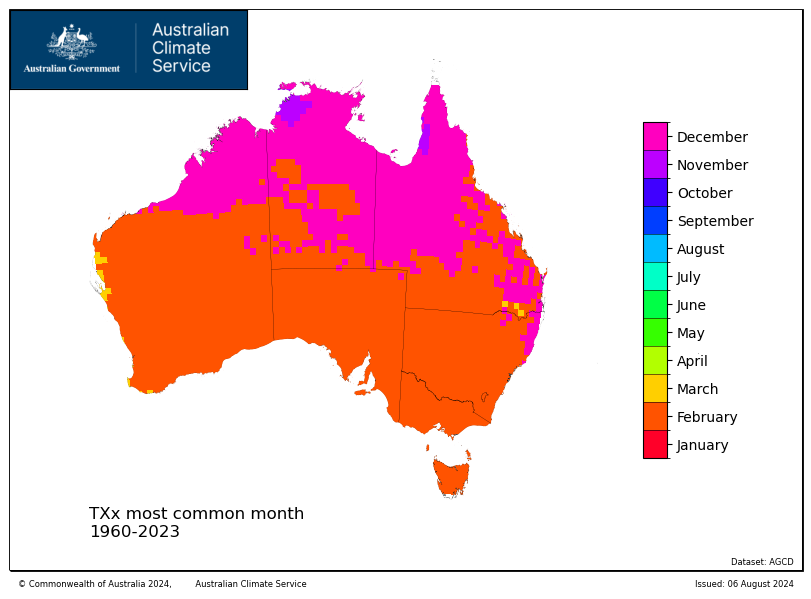

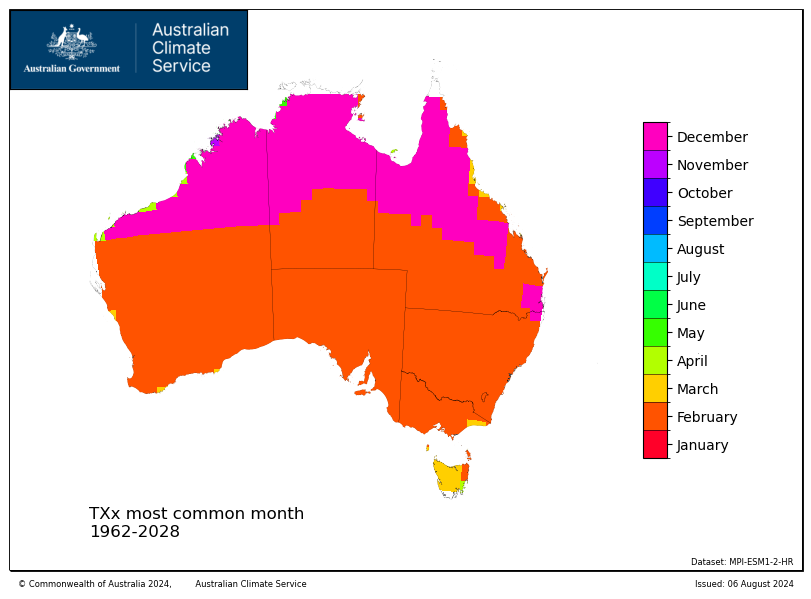

In [12]:
for i, dx in enumerate([ds_obs, ds]):
    fig, ax = plot_acs_hazard(
        data=dx.month_mode,
        title=f"TXx most common month",
        date_range=date_range[i],
        cmap=plt.cm.gist_rainbow,
        cbar_extend="neither",
        ticks=np.arange(0.5, 12.5),
        tick_labels=list(calendar.month_name)[1:],
        cbar_label=None,
        dataset_name=dataset_name[i],
        outfile=home / f"figures/{index.lower()}_map_month_mode_{dataset_name[i]}.png",
        **plot_kwargs,
    )

## Year of maximum TXx

In [16]:
dt = ds_obs[var].copy().compute()
dt.coords["time"] = dt.event_time.dt.year
ds_obs["year_max"] = dt.idxmax("time")

dt = (
    ds[var]
    .stack(time=["init_date", "ensemble", "lead_time"], create_index=False)
    .T.copy()
    .compute()
)
dt.coords["time"] = dt.event_time.dt.year
ds["year_max"] = dt.idxmax("time").T
ds["year_max"]

<xarray.DataArray 'year_max' (lat: 30, lon: 42)> Size: 10kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 240B -42.55 -41.61 -37.87 ... -14.49 -13.56 -12.62
  * lon      (lon) float64 336B 114.4 115.3 116.2 117.2 ... 150.9 151.9 152.8
    height   float64 8B 2.0

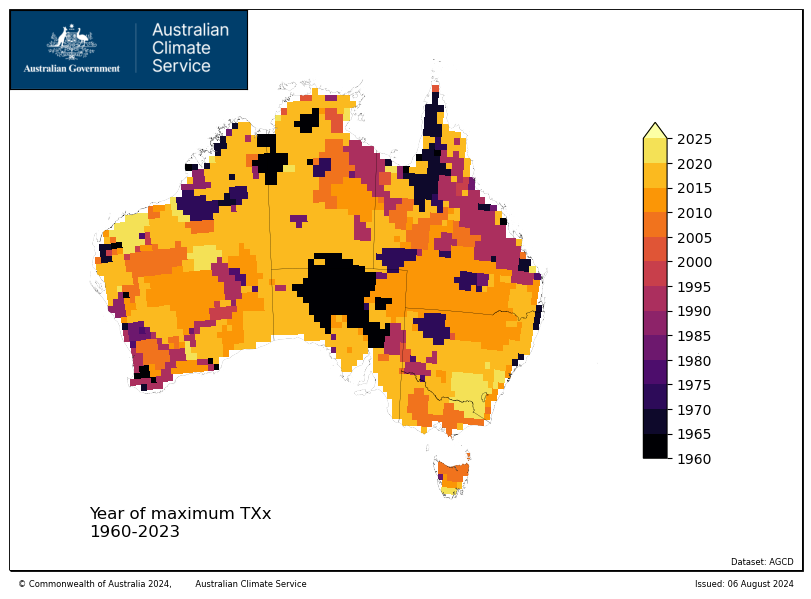

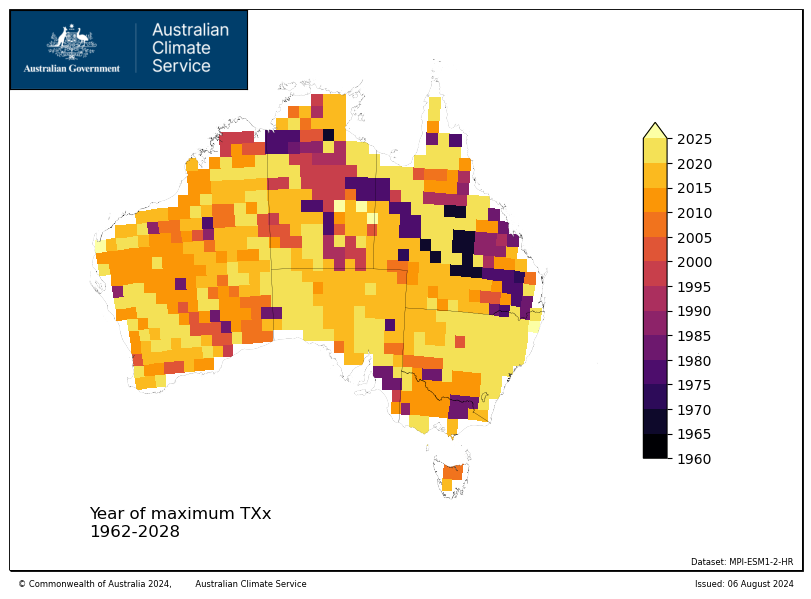

In [18]:
for i, dx in enumerate([ds_obs, ds]):
    fig, ax = plot_acs_hazard(
        data=dx.year_max,
        title=f"Year of maximum TXx",
        date_range=date_range[i],
        cmap=cmap_dict["inferno"],
        cbar_extend="max",
        ticks=np.arange(1960, 2026, 5),
        tick_labels=None,
        cbar_label=None,
        dataset_name=dataset_name[i],
        outfile=home / f"figures/{index.lower()}_map_max_year_{dataset_name[i]}.png",
        **plot_kwargs,
    )
    plt.show()

# Maps of TXx median and maximum


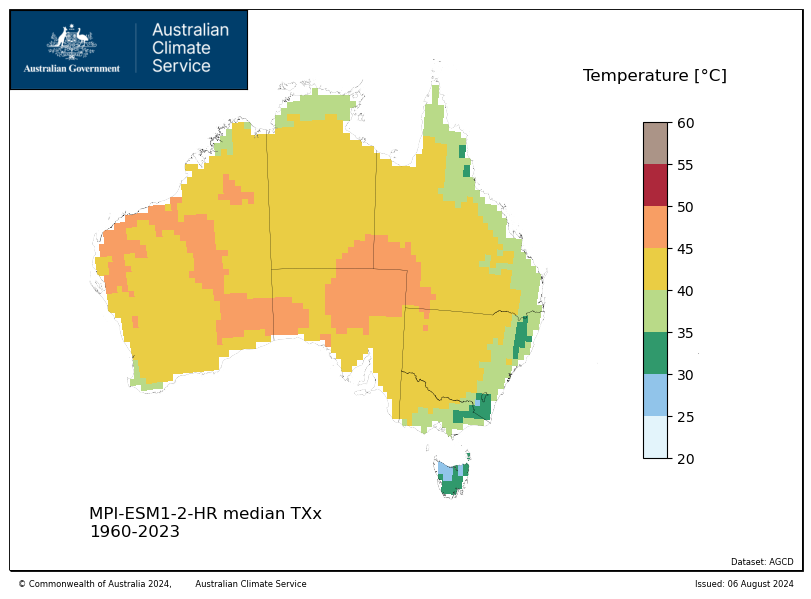

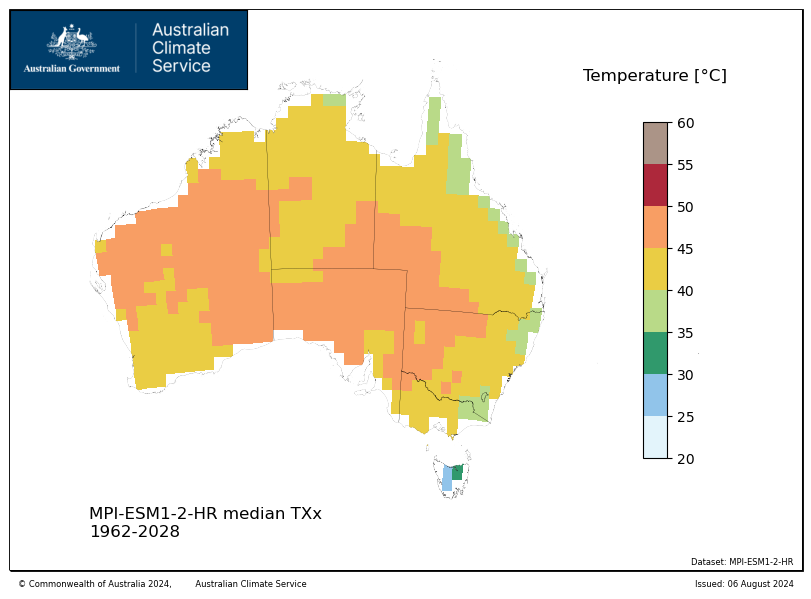

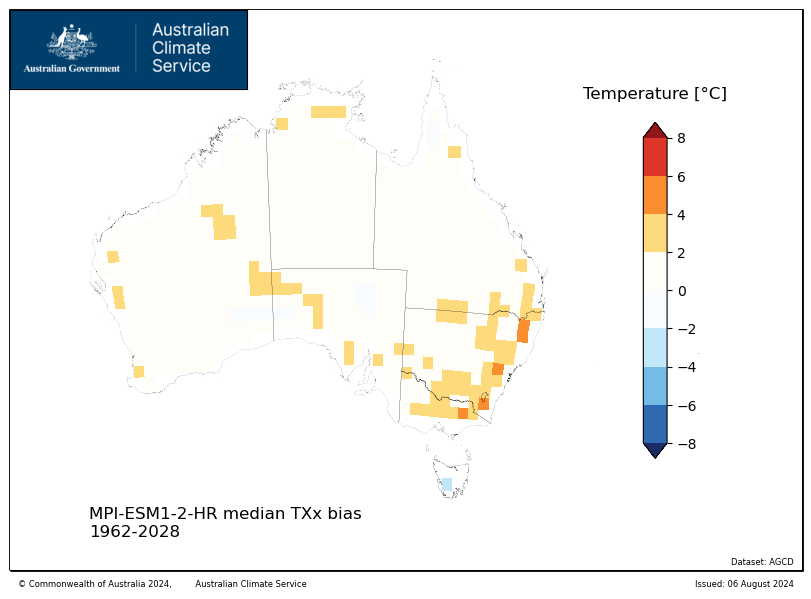

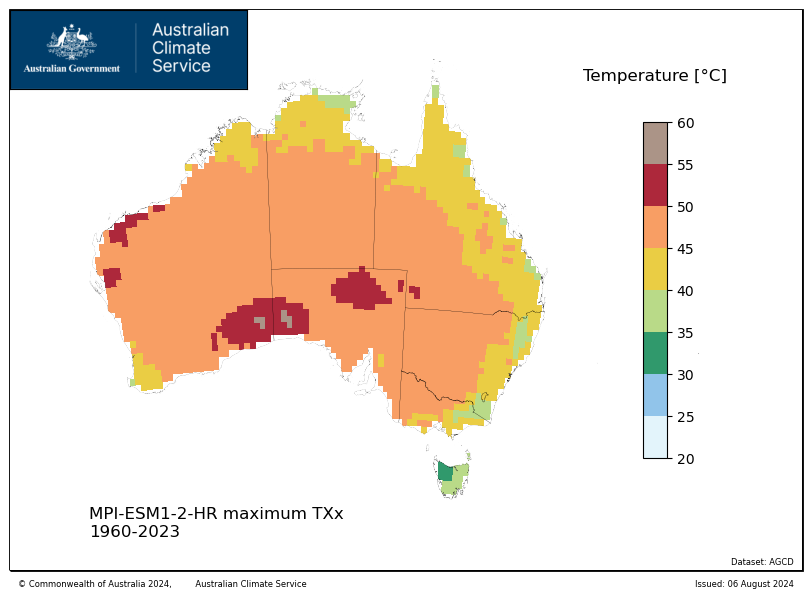

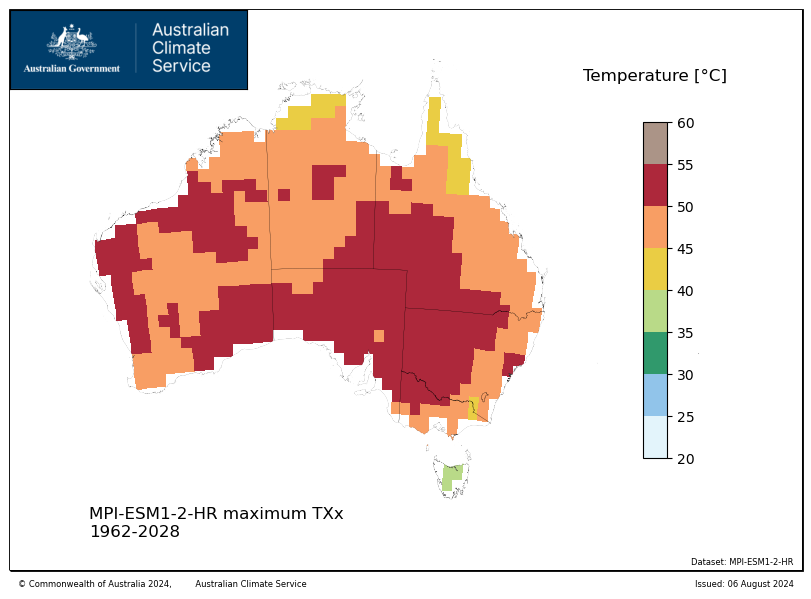

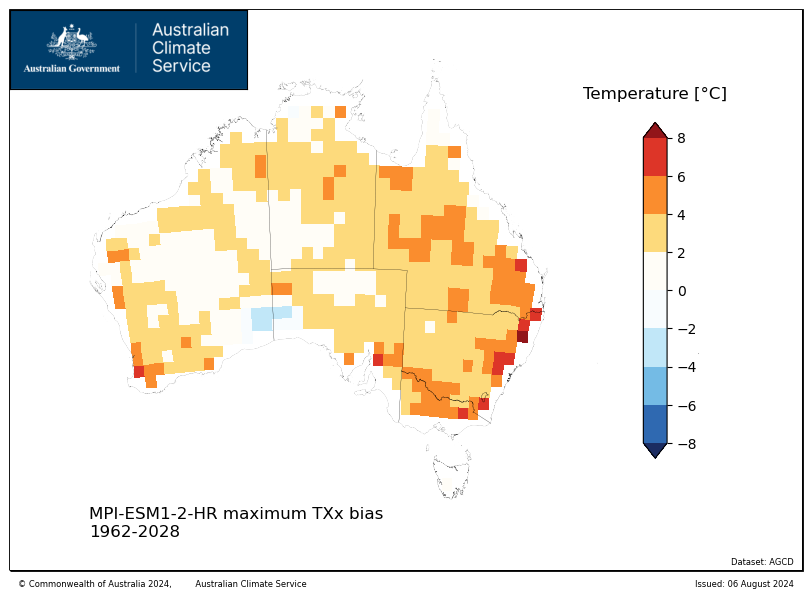

In [20]:
ds_obs["txx_median"] = ds_obs[var].median("time")
ds_obs["txx_maximum"] = ds_obs[var].max("time")
ds["txx_median"] = ds[var].median(["ensemble", "lead_time", "init_date"])
ds["txx_maximum"] = ds[var].max(
    [d for d in ds.dims if d in ["time", "ensemble", "lead_time", "init_date"]]
)

for j, metric in enumerate(["median", "maximum"]):
    nvar = f"txx_{metric}"
    for i, da in enumerate([ds_obs, ds]):

        fig, ax = plot_acs_hazard(
            data=da[nvar],
            title=f"{model} {metric} {index}",
            date_range=date_range[i],
            cmap=cmap_dict["tasmax"],
            cbar_extend="neither",
            ticks=np.arange(20, 65, 5),
            tick_labels=None,
            cbar_label=units,
            dataset_name=dataset_name[i],
            outfile=home
            / f"figures/{index.lower()}_map_{metric.lower()}_{dataset_name[i]}.png",
            **plot_kwargs,
        )

    # Model Obs Difference
    da_obs_regrid = regrid_like(ds_obs[nvar], ds[nvar])
    bias = ds[nvar] - da_obs_regrid
    fig, ax = plot_acs_hazard(
        data=bias,
        title=f"{model} {metric} {index} bias",
        date_range=date_range[1],
        cmap=cmap_dict["anom"],
        cbar_extend="both",
        ticks=np.arange(-8, 9, 2),
        tick_labels=None,
        cbar_label=units,
        dataset_name=dataset_name[0],
        outfile=home
        / f"figures/{index.lower()}_map_{metric}_{dataset_name[1]}_bias.png",
        **plot_kwargs,
    )

# Distribution parameters

## AGCD


In [26]:
ds = ds.isel(lead_time=slice(1, None), drop=True)  # drop first lead time
ds_stacked = ds.stack({"sample": ["ensemble", "init_date", "lead_time"]})

In [27]:
file_obs_params_s = file.parent / (file_obs.stem + "_params_stationary.nc")
file_obs_params_ns = file.parent / (file_obs.stem + "_params_nonstationary.nc")
file_params_s = file.parent / (file.stem + "_params_stationary.nc")
file_params_ns = file.parent / (file.stem + "_params_nonstationary.nc")

In [28]:
%%time

# Stationary parameters
if not file_obs_params_s.exists():
    # ~ 5min
    theta_s_obs = eva.fit_gev(ds_obs[var].chunk({"time": -1}), stationary=True, core_dim="time")
    theta_s_obs = theta_s_obs.to_dataset(name=var)
    theta_s_obs.to_netcdf(file_obs_params_s, compute=True)

theta_s_obs = xr.open_dataset(file_obs_params_s)[var]
theta_s_obs


CPU times: user 3.71 ms, sys: 19.5 ms, total: 23.2 ms
Wall time: 119 ms


<xarray.DataArray 'tasmax' (lat: 63, lon: 81, theta: 3)> Size: 122kB
[15309 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 504B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon      (lon) float64 648B 113.5 114.0 114.5 115.0 ... 152.5 153.0 153.5
    height   float64 8B ...
  * theta    (theta) <U5 60B 'shape' 'loc' 'scale'

In [29]:
%%time

# Non-stationary parameters
covariate_obs = ds_obs.time.dt.year
if not file_obs_params_ns.exists():
    # ~ 14min
    theta_obs = eva.fit_gev(
        ds_obs[var], covariate=covariate_obs, stationary=False, core_dim="time"
    )
    theta_obs = theta_obs.to_dataset(name=var)

    theta_obs.to_netcdf(file_obs_params_ns, compute=True)
theta_obs = xr.open_dataset(file_obs_params_ns)[var]
theta_obs


CPU times: user 10.1 ms, sys: 4.28 ms, total: 14.4 ms
Wall time: 33.7 ms


<xarray.DataArray 'tasmax' (lat: 63, lon: 81, theta: 5)> Size: 204kB
[25515 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 504B -43.5 -43.0 -42.5 -42.0 ... -12.0 -11.5 -11.0
  * lon      (lon) float64 648B 113.5 114.0 114.5 115.0 ... 152.5 153.0 153.5
    height   float64 8B ...
  * theta    (theta) <U6 120B 'shape' 'loc0' 'loc1' 'scale0' 'scale1'

## Model


In [30]:
%%time

# Stationary parameters (~7 mins)
if not file_params_s.exists():
    theta_s = eva.fit_gev(ds_stacked[var], stationary=True, core_dim="sample")
    theta_s = theta_s.to_dataset(name=var)
    theta_s.to_netcdf(file_params_s, compute=True)
theta_s = xr.open_dataset(file_params_s)[var]
theta_s

CPU times: user 9.02 ms, sys: 2.01 ms, total: 11 ms
Wall time: 76.7 ms


<xarray.DataArray 'tasmax' (lat: 32, lon: 42, theta: 3)> Size: 32kB
[4032 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 256B -42.55 -41.61 -38.81 ... -13.56 -12.62 -11.69
  * lon      (lon) float64 336B 114.4 115.3 116.2 117.2 ... 150.9 151.9 152.8
    height   float64 8B ...
  * theta    (theta) <U5 60B 'shape' 'loc' 'scale'

In [31]:
%%time

# Non-stationary parameters (~X mins)
covariate = ds_stacked.time.dt.year
if not file_params_ns.exists():
    theta = eva.fit_gev(
        ds_stacked[var], covariate=covariate, stationary=False, core_dim="sample"
    )
    theta = theta.to_dataset(name=var)
    theta.to_netcdf(file_params_ns, compute=True)
theta = xr.open_dataset(file_params_ns)[var]
theta


CPU times: user 30.4 ms, sys: 4.42 ms, total: 34.8 ms
Wall time: 67.9 ms


<xarray.DataArray 'tasmax' (lat: 32, lon: 42, theta: 5)> Size: 54kB
[6720 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 256B -42.55 -41.61 -38.81 ... -13.56 -12.62 -11.69
  * lon      (lon) float64 336B 114.4 115.3 116.2 117.2 ... 150.9 151.9 152.8
    height   float64 8B ...
  * theta    (theta) <U6 120B 'shape' 'loc0' 'loc1' 'scale0' 'scale1'

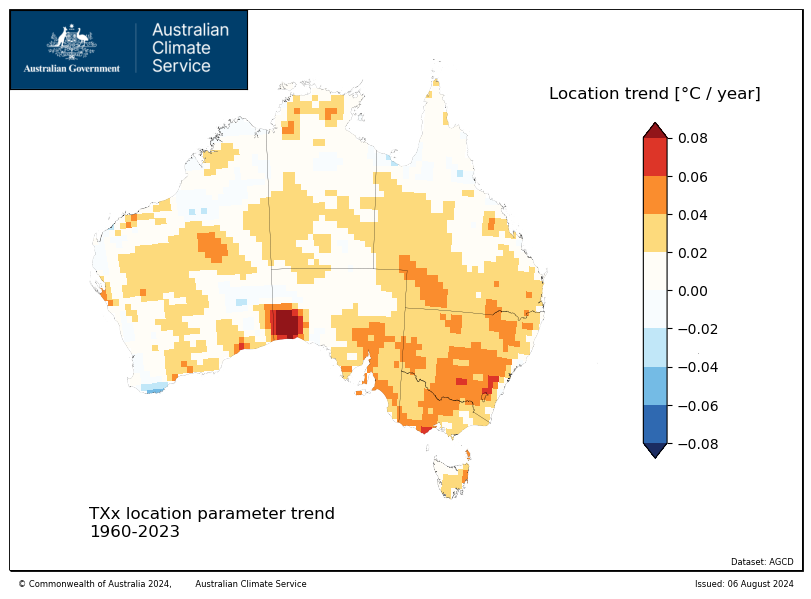

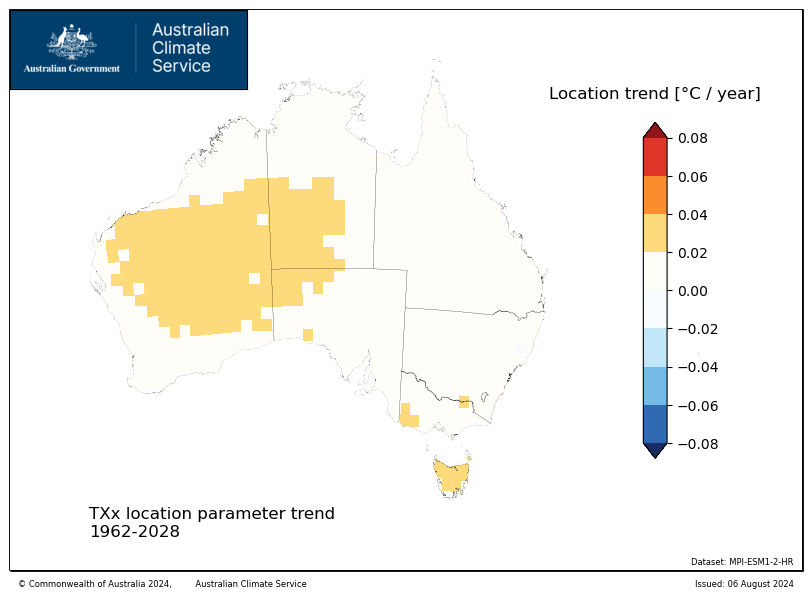

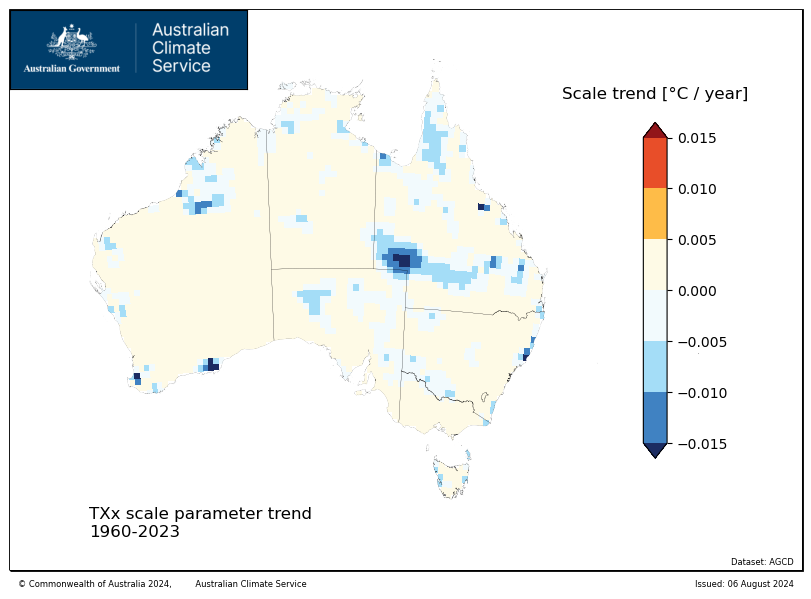

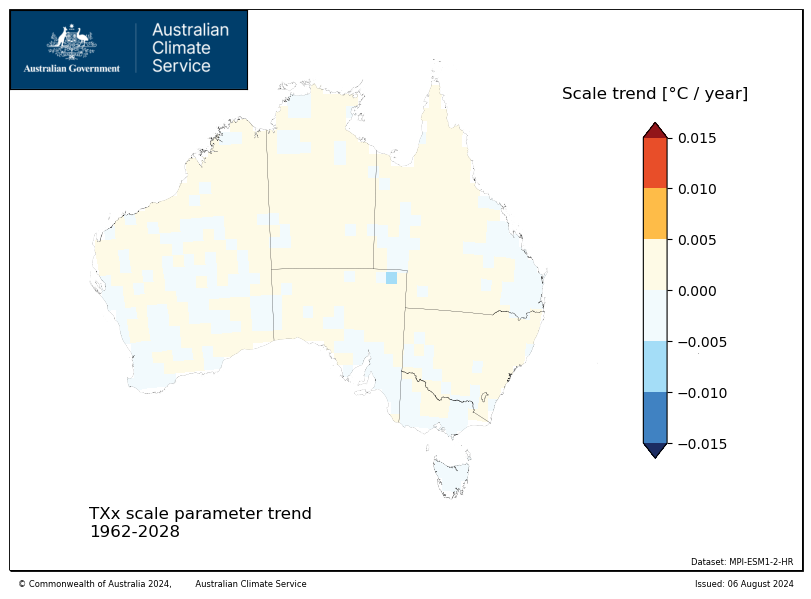

In [33]:
# Plot location and scale parameter trends
for j, param, ticks in zip(
    [2, 4],
    ["location", "scale"],
    [np.arange(-0.08, 0.09, 0.02), np.arange(-0.015, 0.016, 0.005)],
):
    for i, dx in enumerate([theta_obs, theta]):
        fig, ax = plot_acs_hazard(
            data=dx.isel(theta=j),
            title=f"TXx {param} parameter trend",
            date_range=date_range[i],
            cmap=cmap_dict["anom"],
            cbar_extend="both",
            ticks=ticks,
            tick_labels=None,
            cbar_label=f"{param.capitalize()} trend [°C / year]",
            dataset_name=dataset_name[i],
            outfile=home
            / f"figures/{index.lower()}_map_{param}_trend_{dataset_name[i]}.png",
            **plot_kwargs,
        )
        plt.show()

In [1]:
home = Path("/g/data/xv83/unseen-projects/outputs/hazards")
from dataclasses import dataclass

Hazard = namedtuple("Hazard", "index variable units ticks cmap")
txx = Hazard(
    "TXx",
    "tasmax",
    "Temperature [°C]",
    np.arange(20, 60 + 5, 5),
    cmap=cmap_dict["tasmax"],
)
rxx = Hazard("RXx", "pr", "Rainfall [mm/day]", np.arange(0, 20 + 2, 2), cmap_dict["pr"])
txx

NameError: name 'Path' is not defined

## Return values

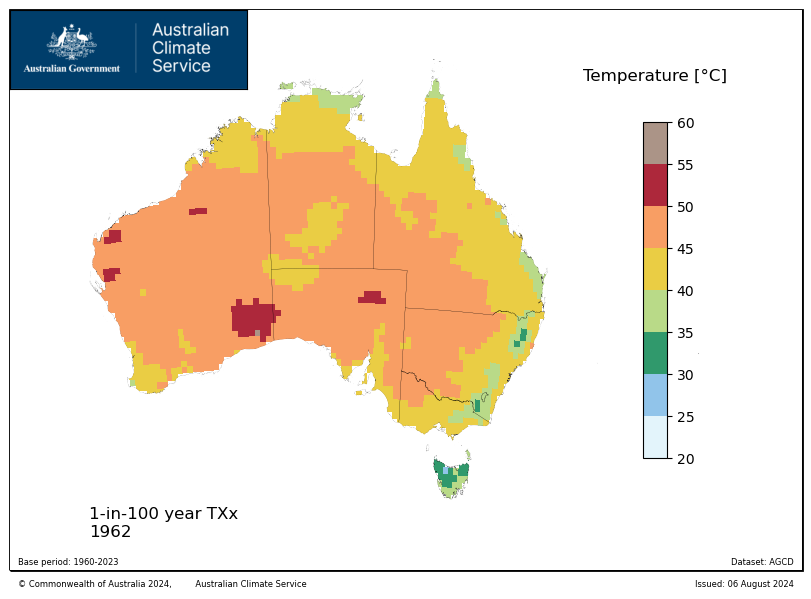

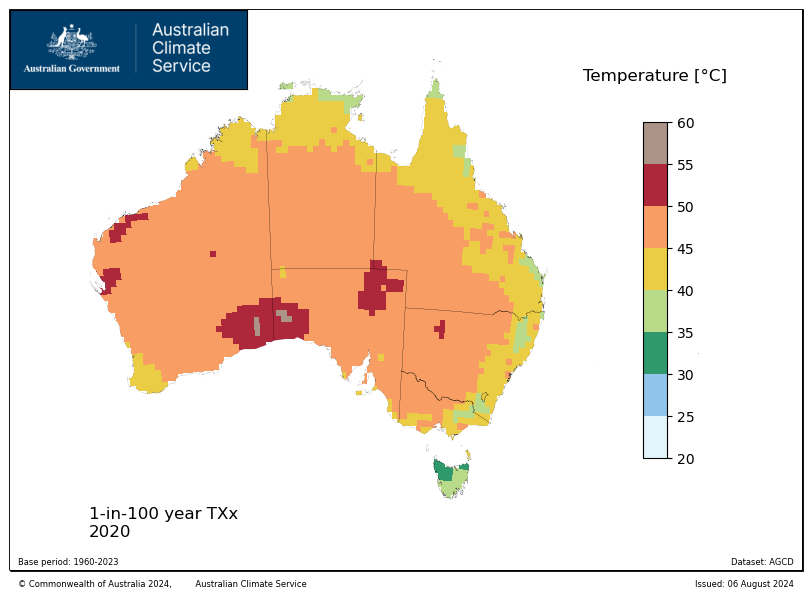

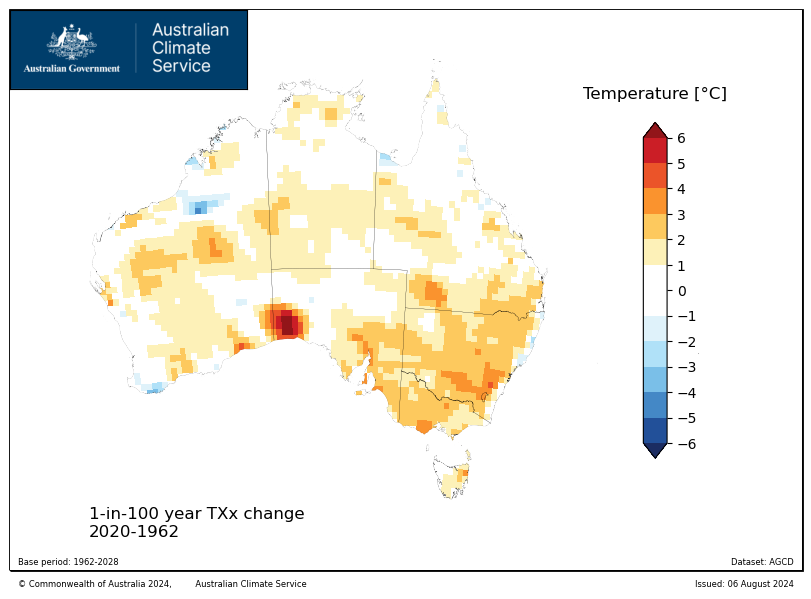

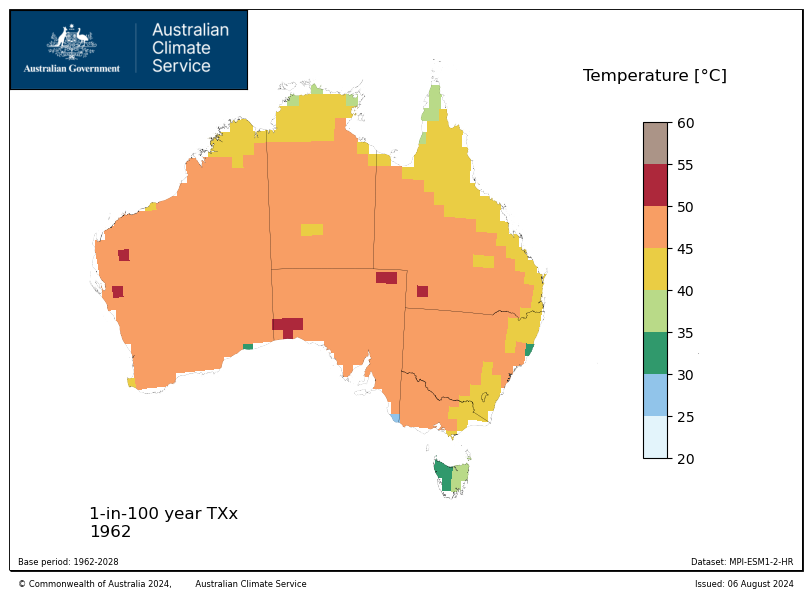

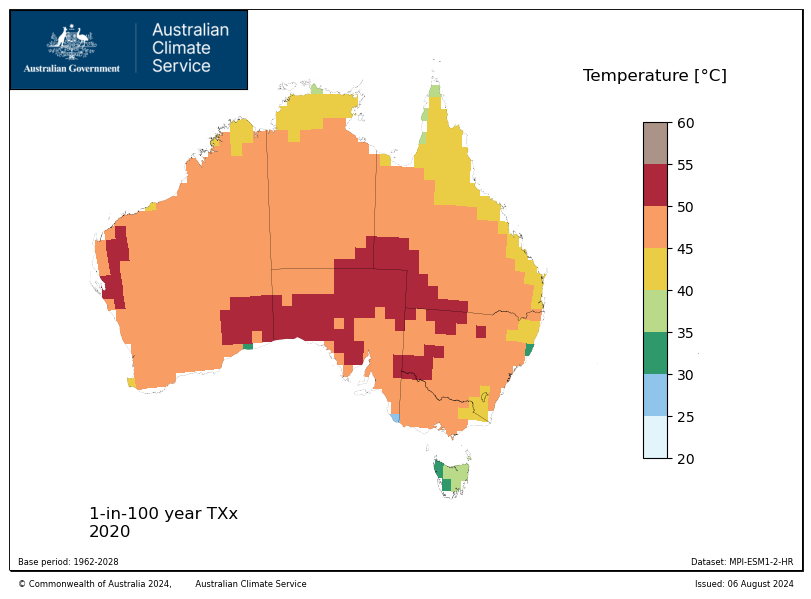

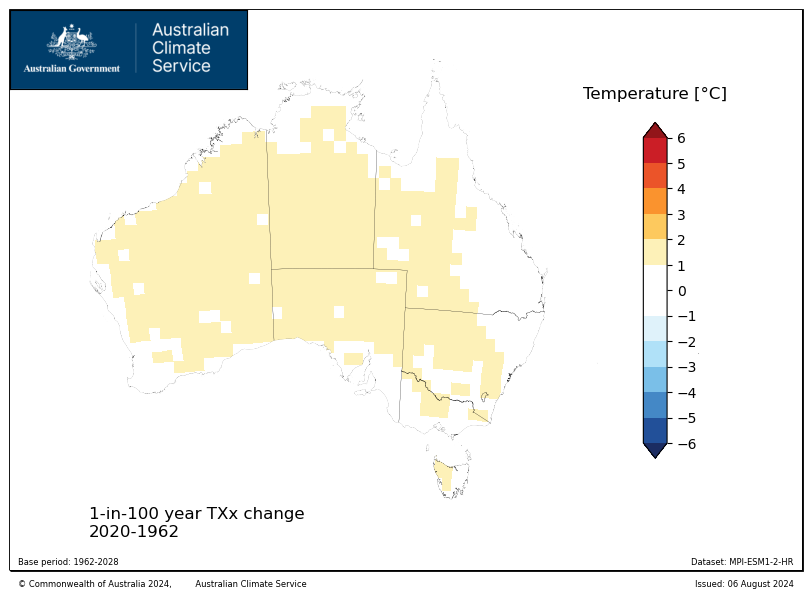

In [37]:
return_period = 100
times = xr.DataArray([1962, 2020], dims="time")

rl = eva.get_return_level(return_period, theta, times)
rl_obs = eva.get_return_level(return_period, theta_obs, times)

for i, dx in enumerate([rl_obs, rl]):
    for j, time in enumerate(times.values):
        fig, ax = plot_acs_hazard(
            data=dx.isel(time=j),
            title=f"1-in-{return_period} year {index}",
            date_range=time,
            baseline=date_range[i],
            cmap=cmap_dict["tasmax"],
            cbar_extend="neither",
            ticks=np.arange(20, 60 + 5, 5),
            tick_labels=None,
            cbar_label=units,
            dataset_name=dataset_name[i],
            outfile=home
            / f"figures/{index.lower()}_map_{return_period}-year_return_level_{dataset_name[i]}_{time}.png",
            **plot_kwargs,
        )
        plt.show()

    # Difference
    time_diff = f"{times[1].item()}-{times[0].item()}"
    fig, ax = plot_acs_hazard(
        data=dx.isel(time=1, drop=True) - dx.isel(time=0, drop=True),
        title=f"1-in-{return_period} year {index} change",
        date_range=time_diff,
        baseline=date_range[1],
        cmap=cmap_dict["anom"],
        cbar_extend="both",
        ticks=np.arange(-6, 7, 1),
        tick_labels=None,
        cbar_label=units,
        dataset_name=dataset_name[i],
        outfile=home
        / f"figures/{index.lower()}_map_return_level_{return_period}-year_{dataset_name[i]}_{time_diff}.png",
        **plot_kwargs,
    )
    plt.show()

In [45]:
"-".join([str(t) for t in times.values[::-1]])

'2020-1962'

In [39]:
rl[0].dims[-2:] == ("lat", "lon")

('lon', 'time')